# Computing gradients and linear regression in PyTorch

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Example 1 -- Computing gradients
In PyTorch keeps track of all operations to be able to compute gradients. Consider the function
$$
\Gamma(\theta_1,\theta_2,\theta_3,\theta_4) = \theta_1 \theta_2+ \theta_3 \theta_4
$$

In [15]:
theta1 = torch.tensor(2, requires_grad=True, dtype=torch.float32)
theta2 = torch.tensor(3, requires_grad=True, dtype=torch.float32)
theta3 = torch.tensor(1, requires_grad=True, dtype=torch.float32)
theta4 = torch.tensor(4, requires_grad=True, dtype=torch.float32)

# Forward propagation
z1 = theta1 * theta2
z2 = theta3 * theta4
f = z1 + z2
f.backward() # Compute gradients

print(f"Gamma's derivative w.r.t. theta_1 is {theta1.grad}")
#print(f'theta3.grad: {theta3.grad}')

Gamma's derivative w.r.t. theta_1 is 3.0


$$
\frac{\partial \Gamma}{\partial \theta_1} (\theta_1,\theta_2,\theta_3,\theta_4) = \theta_2 
$$

$$
\frac{\partial \Gamma}{\partial \theta_1} (2,3,1,4) = 3
$$

## Disable gradient computations with `no_grad()`
Disabling gradient calculation is useful for inference, when you are sure that you will not call `Tensor.backward()`. It will reduce memory consumption for computations that would otherwise have `requires_grad=True`.


In [3]:
x = torch.tensor([1.0], requires_grad=True) # Crucial use floats for this
with torch.no_grad():
    y = x * 2
print(y.requires_grad)
print(x.requires_grad)

# To detach x from the computational graph, use the `.detach()` function
x = x.detach()
print(x.requires_grad)
print(y.requires_grad)



False
True
False
False


## Example 2 -- Training a one-dimensional linear regression model - Manual version
### Generate data
We generate data based on the very simple model 
$$ y = wx + b + \epsilon, \quad\quad x\sim \mathcal{N}(0,2^2)\text{ and }\epsilon \sim \mathcal{N}(0,0.6^2)$$
where $w=-1.5$ and $b=8.5$.

In [4]:
N = 100      # number of training data
N = 100      # number of training data
w_ref = -1.5 # We want to learn this parameter
b_ref = 8.5  # We want to learn this parameter

x = 2*torch.randn(N, dtype=torch.float)
noise = 0.6*torch.randn(N, dtype=torch.float)
y = w_ref*x + b_ref + noise


### Create loss function ($l^2$-loss function)
We use the mean squared error loss function. That is 
$$\frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2. $$

In [5]:
def MSE_loss(prediction, target): # Mean squared error (MSE)
    return (prediction-target).pow(2).mean()

### Use gradient descent to find values for $w$ and $b$ using the data $x$ and $y$
We choose the model $f_{w,b}(x) = wx +b$, and let $\theta = (w,b)$
$$
\Gamma(\theta) = \frac{1}{m}\sum_{k=1}^{m} (wx^{(k)}+b - y^{(k)})^2
$$

Recall the gradient descent step
$$\theta^{(i+1)} = \theta^{(i)} - \alpha_i \nabla \Gamma(\theta^{(i)}),$$
where $\alpha_i > 0$ is the learning rate (also called step length).


In [16]:
w = torch.tensor(0, dtype=torch.float, requires_grad=True)
b = torch.tensor(0, dtype=torch.float, requires_grad=True)

number_of_epochs = 1000
learning_rate = 0.01 # alpha
for iter in range(number_of_epochs):
    y_pred = w*x+b
    loss = MSE_loss(y_pred,y)
    loss.backward() # Compute gradients
    # Update weights, without tracking the computations
    with torch.no_grad():
        w = w - learning_rate*w.grad
        b = b - learning_rate*b.grad
    # In the update step above, these have been set to False
    w.requires_grad = True
    b.requires_grad = True

print(w)
print(b)
y_pred = w*x+b
print(MSE_loss(y_pred,y))

tensor(-1.4902, requires_grad=True)
tensor(8.4482, requires_grad=True)
tensor(0.3699, grad_fn=<MeanBackward0>)


### Plot the solution

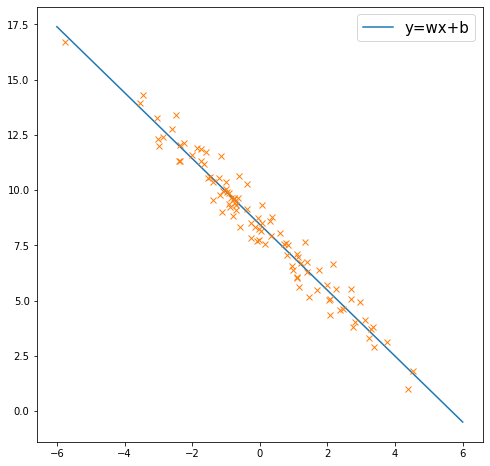

In [17]:
x_equi = torch.linspace(-6,6,101)
y_pred = w*x_equi + b

plt.figure(figsize=(8,8))
plt.plot(x_equi.detach().numpy(), y_pred.detach().numpy(), label='y=wx+b')
plt.plot(x,y, 'x')
plt.legend(fontsize=15)
plt.show()


## Example 3 -- Training a one-dimensional linear regression model - Automatic version
### Create data loader object

In [8]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
print(x.shape)


x = x.view([-1,1]) # [Training_set_size, input_dimension]
y = y.view([-1,1]) # [Training_set_size, output_dimension]

train_ds = TensorDataset(x, y)

batch_size = 10
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

torch.Size([100])


In [23]:


# Build model
input_size = 1
output_size = 1

model = nn.Sequential(
    nn.Linear(input_size, output_size), # An affine map: Ax + b
)

#model = torch.nn.Sequential(
#    torch.nn.Linear(in_features=input_size, out_features=5),
#    torch.nn.ReLU(),
#    torch.nn.Linear(in_features=5, out_features=10),
#    torch.nn.ReLU(),
#    torch.nn.Linear(in_features=10, out_features=10),
#    torch.nn.ReLU(),
#    torch.nn.Linear(in_features=10, out_features=output_size)
#)

# Print model parameters
for name, param in model.named_parameters():
    print(name, param)

# Create loss function
loss_fn = nn.MSELoss()


# Choose optimization rule
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


0.weight Parameter containing:
tensor([[-0.2707]], requires_grad=True)
0.bias Parameter containing:
tensor([0.2643], requires_grad=True)


Check out different optimizers here: https://pytorch.org/docs/stable/optim.html#algorithms

### Train model

In [25]:
log_epochs = 10
num_epochs = 200

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        # 1. Generate predictions
        pred = model(x_batch) 

        # 2. Calculate loss
        loss = loss_fn(pred, y_batch)

        # 3. Compute gradients
        loss.backward()

        # 4. Update parameters using gradients
        optimizer.step()

        # 5. Reset the gradients to zero
        optimizer.zero_grad()
        
    if epoch % log_epochs== 0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

Epoch 0  Loss 47.5906
Epoch 10  Loss 1.6463
Epoch 20  Loss 0.3452
Epoch 30  Loss 0.2924
Epoch 40  Loss 0.3688
Epoch 50  Loss 0.4406
Epoch 60  Loss 0.2964
Epoch 70  Loss 0.1894
Epoch 80  Loss 0.5939
Epoch 90  Loss 0.2582
Epoch 100  Loss 0.2605
Epoch 110  Loss 0.3625
Epoch 120  Loss 0.2145
Epoch 130  Loss 0.3908
Epoch 140  Loss 0.4296
Epoch 150  Loss 0.3807
Epoch 160  Loss 0.1126
Epoch 170  Loss 0.4629
Epoch 180  Loss 0.0962
Epoch 190  Loss 0.4679


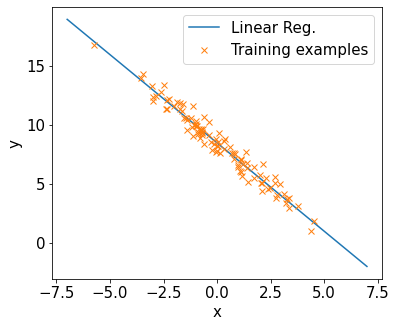

In [26]:
X_test = torch.linspace(-7, 7, steps=100, dtype=torch.float32).reshape(-1, 1)

y_pred = model(X_test).detach().numpy()


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_test, y_pred,)
plt.plot(x, y, 'x')
plt.legend(['Linear Reg.', 'Training examples'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

In [12]:
for name, param in model.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[-1.4931]], requires_grad=True)
0.bias Parameter containing:
tensor([8.4467], requires_grad=True)
